# Mathematical methods for bioengineers - Coursework 2
Victoire de Saléon-Terras - December 2022

This coursework analyses data from the following paper : C.-H. Yu, J. N. Stirman, Y. Yu, R. Hira and S.L. Smith, Diesel2p mesoscope with dual independent scan engines for flexible capture of dynamics in distributed neural circuitry, Nature Communications 12:6639, 2021. The paper describes two-photon calcium imaging from the cortex of a mouse, with a novel instrument that allows collection of data from a large number of neurons simultaneously.

Here are the different libraries and functions used for the study:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy import signal
from math import factorial
from random import random
import pandas as pd
from time import time
start = time()

## 1. Introduction
### 1.1. Load datasets
First, we load the calcium umaging dataset using the skeleton code 'skel.py'.

In [2]:
dFonF1 = np.load("data/DFF_file3_ch1.npy")       # fluorescence time series ch1
n1,N1 = np.shape(dFonF1)                         # number of cells, number of frames
dFonF2 = np.load("data/DFF_file3_ch2.npy")       # fluorescence time series ch2
n2,N2 = np.shape(dFonF2)                         # number of cells, number of frames
dFonF = np.concatenate((dFonF1, dFonF2[:,0:N1])) # combining both channels
n,N = np.shape(dFonF)                            # number of cells, number of frames
print('dimensions of fluorescences time series: nb of cells x nb of frames')
print('ch1: ', n1, N1)
print('ch2: ', n2, N2)
print('concatenate: ', n, N)

# get coordinates of cells in space
XY1 = np.load("data/coord_file3_ch1.npy")
XY2 = np.load("data/coord_file3_ch2.npy")
xc1 = XY1[0,:]; yc1 = XY1[1,:]; xc2 = XY2[0,:]; yc2 = XY2[1,:]
xc = np.hstack((xc1, xc2+1500))                  # combining both channels
yc = np.hstack((yc1, yc2))

# time
fr = 7.6                                        # frame rate in Hz
dt = 1/fr                                       # time interval in seconds
t = np.linspace(0,(N-1)*dt,N)

dimensions of fluorescences time series: nb of cells x nb of frames
ch1:  2167 5680
ch2:  2088 5684
concatenate:  4255 5680


The two channels are arranged physically side by side, and imaged simultaneously. Thus, the two datasets are merged: the fluorescence time series of the channel 2 are concatenated after the time series of the channel 1. The x and y coordinates of the channel 2 are also stacked after the x and y coordinates of the channel 2 with an offset of $1500\mu m $ for the x coordinates to correspond to the real localisation of the neurons.
### 1.2. Physical locations of the cells
In the 2D representation of the cells below, each dot corresponds to a neuron. The neurons from the channel 1 correspond to the neurons with $x<1500 \mu m$ and the neurons from the channel 2 correspond to the neurons with $x>1500 \mu m$.

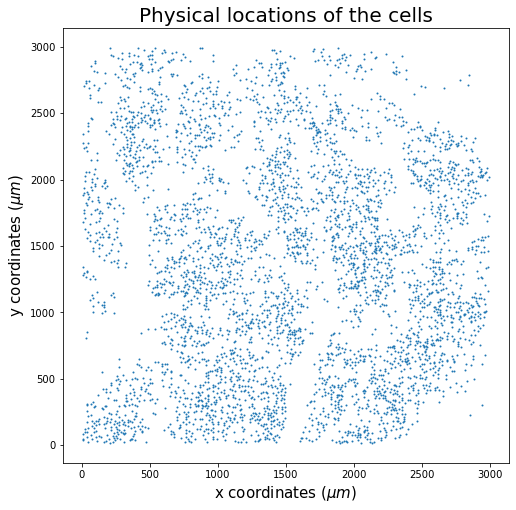

In [3]:
fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(xc,yc,s=1)
ax.set_xlabel('x coordinates ($\mu m$)',fontsize=15)
ax.set_ylabel('y coordinates ($\mu m$)',fontsize=15)
plt.title('Physical locations of the cells',fontsize=20)
plt.show()

## 1.3. Fluorescence time series
We plot the raw fluorescence time series $\Delta F/F$ of the whole population of neurons. The neurons from the channel 1 have a Cell ID lower than 2167 (cf section 1.1.) and the others are from the channel 2.

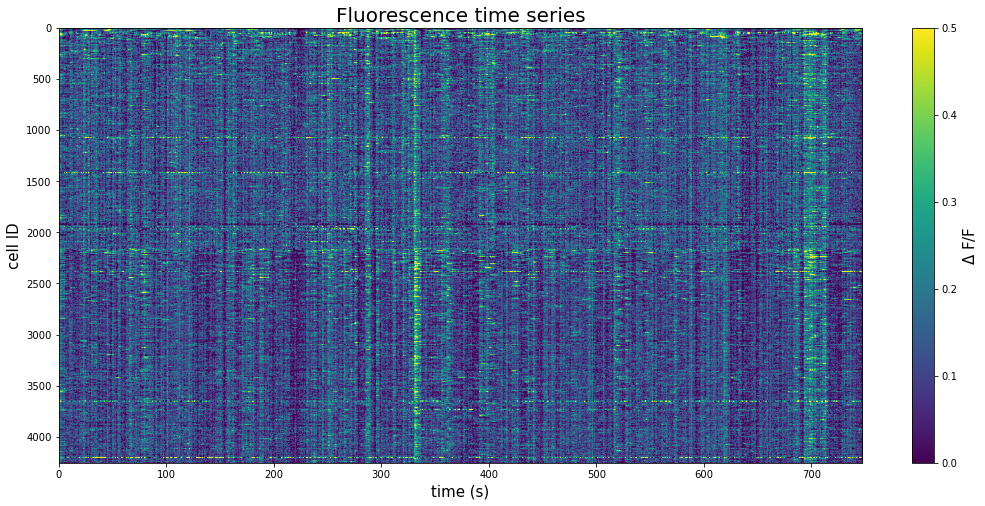

In [4]:
fig,ax = plt.subplots(figsize=(18,8))
plt.imshow(dFonF,aspect='auto',clim=[0,0.5],cmap=plt.cm.viridis)
cbar4 = plt.colorbar()
cbar4.ax.set_ylabel(r'$\Delta$ F/F',fontsize=15)
plt.title('Fluorescence time series',fontsize=20)

# setting x ticks to time (s) and not time indices
step_x = int(100/dt)                # step between consecutive labels
x_positions = np.arange(0,N,step_x) # pixel count at label position
x_labels = t[::step_x].astype(int)  # labels
plt.xticks(x_positions, x_labels)
plt.xlabel('time (s)',fontsize=15)

plt.ylabel('cell ID',fontsize=15)
plt.show()

## 1.4. Smoothing of fluorescence time series
Later in this coursework, we are going to study a network based on this neuron population, where the connectivity of the neurons depends on the correlation between their fluorescence time series. In the upper part of the graph showed in section 1.5, we observe that the fluorescence time series is noisy, and some cells are noisier than others. This can affect the calculation of the correlation coefficients, but what we are interested in in this calculation is only the correlation between the peaks, not their noise.

To remove the noise unequally important in all the fluorescence time series, we apply a high pass (Butterworth) filter to all the dataset, to obtain the noise of all the neurons signals, and then we subtract the filtered values to the dataset (the quickest variations of the fluoresence time series in consecutive frames are mostly due to noise). Then we create a new variable with the smoothed fluorescence time series for each cell: dFonF_s

(reference for the high pass function: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html)

In [5]:
cutoff = 0.1   # Hz
b,a = signal.butter(5, cutoff/(0.5*fr), btype='high', analog=False)
dFonF_s = np.zeros(np.shape(dFonF))
for i in range(n):
    dFonF_s[i,:] = dFonF[i,:]-signal.filtfilt(b,a, dFonF[i,:])

The chosen cutoff frequency is $0.1 Hz$, then we normalize this frequency with half of the frame rate (Nyquist frequency), and we use this value in the fifth order high pass filter.
## 1.5. Fluorescence time series for 5 cells
We plot the raw fluorescence time series for 5 cells, and the corresponding smoothed time series. In the raw fluorescence time series, we observe a difference in noise: the Signal to Noise ratio for cell 728 is higher than for cell 212. This may be due to the position of the neuron: more or less deep in the brain.

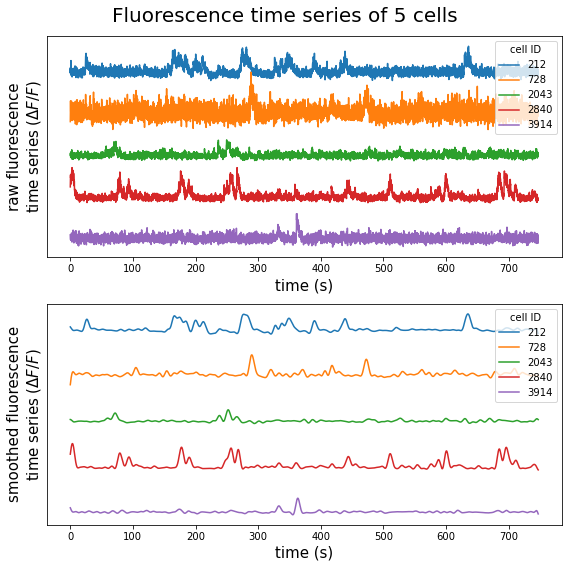

In [6]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,8))
cell_ID = [212,728,2043,2840,3914]
for i in range(5):
    ax1.plot(t,dFonF[cell_ID[i],:]-5*i,label=str(cell_ID[i]))
    filtered = dFonF_s[cell_ID[i],:]
    ax2.plot(t,filtered-5*i,label=str(cell_ID[i]))
ax1.set_yticks([])
ax2.set_yticks([])
ax1.set_xlabel('time (s)',fontsize=15)
ax1.set_ylabel(r"raw fluorescence" "\n" r"time series ($\Delta F/F$)",fontsize=15)
ax2.set_xlabel('time (s)',fontsize=15)
ax2.set_ylabel(r"smoothed fluorescence" "\n" r"time series ($\Delta F/F$)",fontsize=15)
ax1.legend(title='cell ID',loc='upper right')
ax2.legend(title='cell ID',loc='upper right')
plt.suptitle('Fluorescence time series of 5 cells',fontsize=20)
plt.tight_layout()
plt.show()

In these 5 selected cells we see obvious (not buried in the signal noise) calcuim transient. They have different shapes and frequencies, which reflects differents functions of the neurons. We are now able to calculate the matrix of Pearson correlation coefficients.

## 2. Correlation between the calcium fluorescence time series from each cell
### 2.1. Matrix of Pearson correlation coefficients
We use the function np.corrcoef to compute the pearson product-moment correlation coefficients. The value at the $i^{th}$ line and the $j^{th}$ column of the correlation matrix is given by $C_{i,j}/ \sqrt{C_{i,i} C_{j,j}}$ where $C_{i,j}$ is the covariance of the fluorescence time series of the $i^{th}$ cell and the $j^{th}$ cell. By definition, its values are between -1 and 1. The time series of the cells are said to be correlated when their correlation coefficient is close to 1 and uncorrelated when their correlation coefficient is close to 0. Their correlation coefficient is negative when the fluorescence time series of the cells are correlated but evolves in opposite directions.

In [7]:
S = np.corrcoef(dFonF_s)
print(S.shape)

(4255, 4255)


### 2.2. Plot of the correlation matrix
The diagonal values are the highest values (equal to 1) because the fluoresence time series are compared to themselves. In addition we see that the fluorescence time series of the neurons of the channel 2 correlate more among themselves (brighter square in the bottom right).

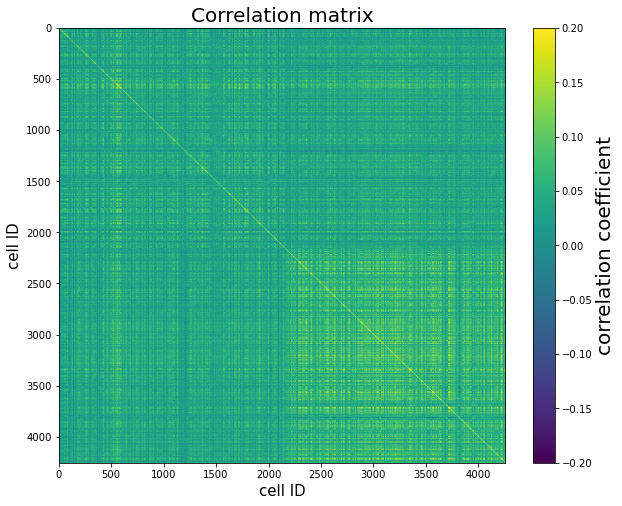

In [8]:
fig,ax = plt.subplots(figsize=(10,8))
plt.imshow(S,aspect='auto',clim=[-0.2,0.2])
cbar = plt.colorbar()
cbar.ax.set_ylabel('correlation coefficient',fontsize=20)
ax.set_xlabel('cell ID',fontsize=15)
ax.set_ylabel('cell ID',fontsize=15)
plt.title('Correlation matrix',fontsize=20)
plt.show()

### 2.3. Distribution of correlation coefficients
The distribution of correlation coefficients is plotted in two different ways:
- on the left: an histogram of the values of the correlation coefficient
- on the right: the value of the correlation coefficient according to the distance between two neurons (as in the paper)

First, we need to select the correlation coefficient of only half of the matrix (the matrix is symmetric), without the diagonal. We also compute the value of three percentiles of the dataset of correlaation coefficients.

In [9]:
ind = np.tri(n,n)-np.eye(n,n)      # bottom triangle - diagonal
S_list = S[ind==1]
tr99=np.percentile(S_list,99)
tr80=np.percentile(S_list,80)
tr50=np.percentile(S_list,50)

Then, in order to plot the value of the correlation coefficient of two neurons according to their distance, we create 1000 $4\mu m$ wide bins and average the value of the corresponding correlation coefficients for each bins.

In [10]:
def distance(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

D = np.zeros((n,n)); D[:] = np.nan
m,dmax=1001,4000                             # number of points and max distance to plot
d = np.linspace(0,dmax,m)
pas = dmax/(m-1)
s = np.zeros((m))                            # this array will contain the sum of the corr coefs for each bins
counts = np.zeros((m))                       # this array will contain the count of the corr coefs for each bins
for i in range(n):
    for j in range(i+1,n):
        D[i,j]=distance(xc[i],yc[i],xc[j],yc[j])
        k = int(D[i,j]/pas)
        s[k]+=S[i,j]
        counts[k]+=1
counts[counts==0]=np.nan                      # to avoid dividing by zero, empty bins are assigned the value np.nan
s = s/counts

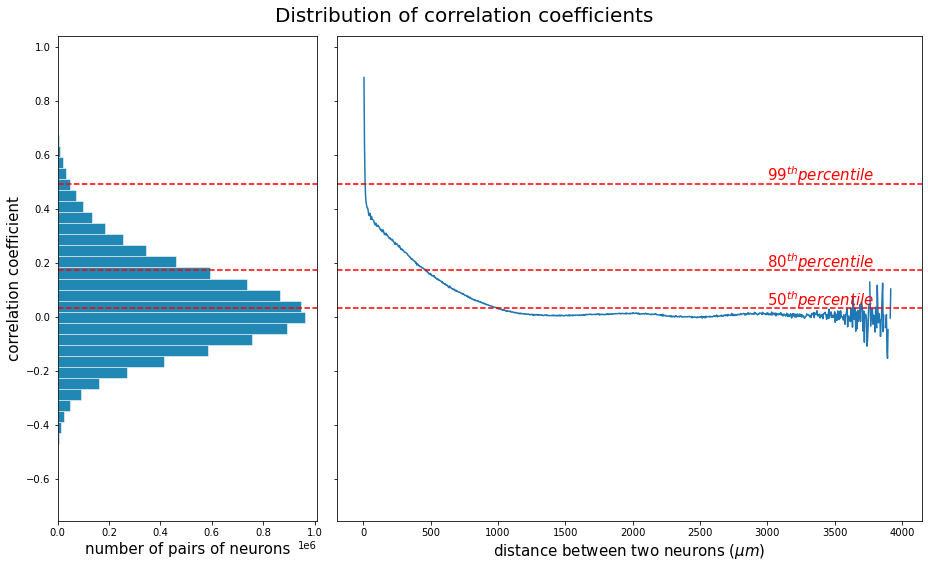

In [11]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(13,8),sharey=True, gridspec_kw={'width_ratios': [1,2.25]})
plt.suptitle('Distribution of correlation coefficients',fontsize=20)

ax1.hist(S_list,bins=40,facecolor = '#2088B2', edgecolor='#FFFFFF', linewidth=0.5,orientation='horizontal')
ax1.set_ylabel('correlation coefficient',fontsize=15)
ax1.set_xlabel('number of pairs of neurons',fontsize=15)

ax2.plot(d,s)

# plot percentiles
ax1.axhline(y=tr99, color='r', linestyle='--')
ax1.axhline(y=tr80, color='r', linestyle='--')
ax1.axhline(y=tr50, color='r', linestyle='--')

ax2.axhline(y=tr99, color='r', linestyle='--')
ax2.annotate('$99^{th} percentile$', xy=(3000,tr99+0.01),fontsize=15,color='r')
ax2.axhline(y=tr80, color='r', linestyle='--')
ax2.annotate('$80^{th} percentile$', xy=(3000,tr80+0.01),fontsize=15,color='r')
ax2.axhline(y=tr50, color='r', linestyle='--')
ax2.annotate('$50^{th} percentile$', xy=(3000,tr50+0.01),fontsize=15,color='r')

ax2.set_xlabel('distance between two neurons ($\mu m$)',fontsize=15)

plt.tight_layout()
plt.show()

## 3. Undirected graph
### 3.1. Adjacency matrix
The $Q^{th}$ percentile is the value below wich $Q$% of the population falls. In this section, we will form an undirected graph, where the nodes represents each neuron, and the edges are binary variables equals to 1 if the correlation coefficient between the time series exceeds the 92th percentile of the distribution of correlation coefficients between different neurons (i.e. we are choosing the threshold to have 8% sparsity of connections).

By definition, to form an undirected graph, the adjacency matrix has to be symmetric (Adj[j,i]=Adj[i,j]). In addition, we will not allow self edges, so we will keep zeros on the diagonal.

In [12]:
tr=np.percentile(S,92)      # 92th percentile
print('threshold: ',tr)
Adj = np.zeros((n,n))
for i in range(n):
    for j in range(i+1,n):  # start at i+1 to avoid changing the diagonals values to 1, to avoid self-edges
        if S[i,j]>=tr:      # if the correlation coefficient between the ith and jth time series exceeds the 92th percentile
            Adj[i,j]=1
            Adj[j,i]=1

threshold:  0.2871234684751394


In [13]:
nn = len(Adj[1,:])                                 # number of nodes
print('number of nodes: ', nn)
degree = np.sum(Adj,1).astype(int)
ne = int(sum(degree)/2)                            # number of edges
print('number of edges: ', ne)
print('sparsity: ', 100*ne/(nn*(nn-1)/2),'%')      # expected sparsity: 8%

number of nodes:  4255
number of edges:  722074
sparsity:  7.978378820348526 %


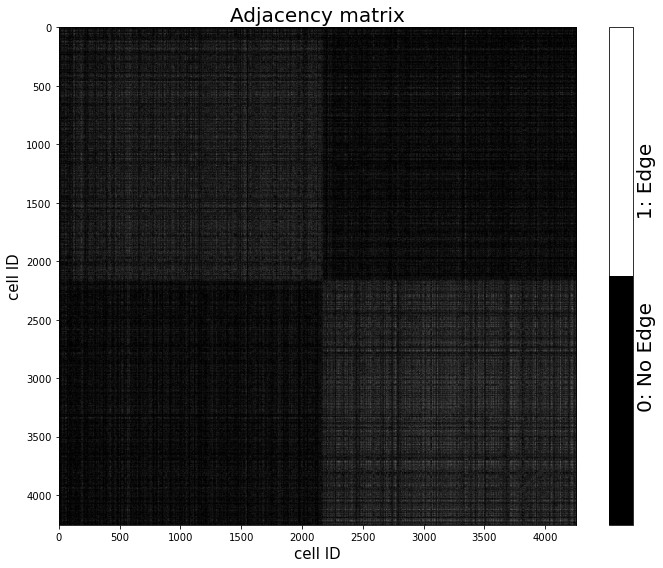

In [14]:
fig,ax = plt.subplots(figsize=(10,8))
img = plt.imshow(Adj, aspect='auto', cmap='binary_r')
ax.set_xlabel('cell ID', fontsize=15)
ax.set_ylabel('cell ID', fontsize=15)

# colorbar
cbar = plt.colorbar(img, boundaries=[-2,0,2],ticks=[])
cbar.set_label('0: No Edge             1: Edge',fontsize = 20)

plt.title('Adjacency matrix', fontsize=20)
plt.tight_layout()
plt.show()

We obeserve two brighter squares. It means that cells with an ID lower than 2167 are more often linked by an edge with other cells with an ID lower than 2167. And cells with an ID higher than 2167 are more often linked by an edge with other cells with an ID higher than 2167. In other words, the fluorence time series of the cells from the two channels are more corelated with those from the same channels.
### 3.2. Plotting undirected graph
According to the previous section, if we choose a 8% sparsity in the undirected graph, we need to draw 722 074 edges. As this represents a very important calculation time, we will draw only 1% of the edges by choosing them randomly, wich will reduce the number of edges to draw to 7 220.

In [15]:
te = 0.01
print('percentage of edges plotted: ', 100*te,'%')
print('approximate number of edges plotted: ', int(te*ne))

percentage of edges plotted:  1.0 %
approximate number of edges plotted:  7220


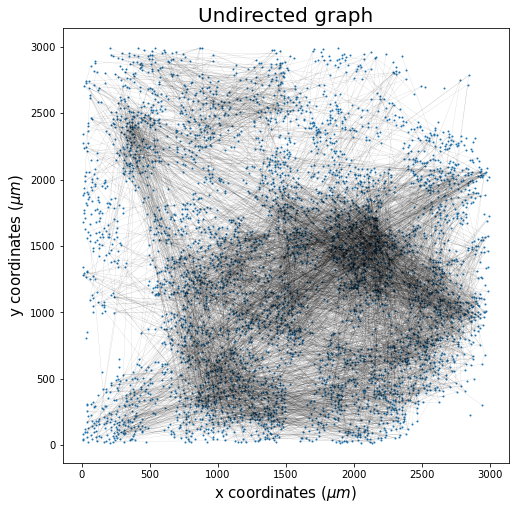

In [16]:
fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(xc, yc, s=1)
for i in range(n):
    for j in range(i+1, n):
        if Adj[i,j]==1:
            if random()<0.01:
                ax.plot([xc[i], xc[j]], [yc[i], yc[j]], alpha=0.5, linewidth=0.1, color='k')
ax.set_xlabel('x coordinates ($\mu m$)', fontsize=15)
ax.set_ylabel('y coordinates ($\mu m$)', fontsize=15)
plt.title('Undirected graph', fontsize=20)
plt.show()

Most of the edges are linking the nodes on the right side of the population (there is a really dense concentration of edges aroud $x=2000\mu m$ and $y=1500\mu m$), wich confirms our observation in the correlation matrix in the section 2.2.
## 4. Graph analysis
In this section, we will use NetworkX, a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. First from the adjacency numpy matrix we create the graph G:

In [17]:
G = nx.from_numpy_matrix(Adj)

### 4.1. Average degree
We calculate the average degree of the nodes by dividing the sum of all the degree of the nodes by the total number of nodes.

In [18]:
ad = int(sum(degree)/nn)
print('average degree :', ad)

average degree : 339


On average, each node is connected to approximately 339 other nodes
### 4.2. Average clustering coefficient
Since the values of the adjacency matrix are binary (0 or 1), the graph is unweighted. For an unweighted graph, the local clustering coefficient $c_i$ of a node $i$ (with a degree $k_i$) is the number of possible triangles $T(i)$ trough that node that exists. The coefficient $c_i$ is expressed as follows:

\begin{equation}
c_i=\frac{2T(i)}{k_i(k_i-1)}
\end{equation}

The average clustering coefficient $ac$ is the local clustering coefficient averaged over all nodes in the graph. As the number of nodes is extremely large in this dataset, we use an approximation function: this function finds an approximate average clustering coefficient for G by repeating 1000 times (trials=1000) the following experiment: choose a node at random, choose two of its neighbors at random, and check if they are connected. The approximate coefficient is the fraction of triangles found over the number of trial.

In [31]:
ac = nx.algorithms.approximation.average_clustering(G, trials=1000, seed=None)
print('average clustering coefficient :', ac)

average clustering coefficient : 0.498


On average, two neighbors of the same node have one in two chance to be connected.
### 4.3. Global clustering coefficient
The global clustering coefficient, also called "transitivity" is the fraction of all possible triangles present in G. Possible triangles are identified by the number of “triads” (or "connected triplets", two edges with a shared node). gc= 3x (number of triangles)/(number of connected triplets).

In [20]:
gc = nx.transitivity(G)
print('global clustering coefficient :',gc)

global clustering coefficient : 0.49829196498854084


We observe that the average clustering coefficient and the global clustering coefficient are equal.
### 4.4. Diameter
The network diameter $D$ is the maximum over all pairs $i,j$ in the network of the shortest path length from $i$ to $j$, $L_{ij}$. It is the shortest route between the most distant nodes. We can calculate the diameter of our network only if all the nodes are connected to at least 1 other node (otherwise, the estimated diameter would be infinite).

In [32]:
print('number of unconnected nodes: ',degree[degree==0].size)
diameter = nx.algorithms.approximation.diameter(G)
print('diameter: ', diameter)
print('log(n)= ', np.log(nn))

number of unconnected nodes:  0
diameter:  5
log(n)=  8.355850041007475


A network is considered as a small world if its diameter is small relative to the total number of nodes in the network. Usually, one wants the diameter to grow no faster than logarithmically as the number of nodes tends to infinity: $D\sim log(n)$. Our network is considered as a small world since, it is easy to get from one node to another because the shortest route between the most distant nodes is only 5 edges.

We will compare all of these network characteristics with the characteristics of a random network in the section 5.
## 5. Comparison with a random network
### 5.1. Erdos-Renyi random network
For comparison, we create a second graph with the characteristic features of an Erdos-Renyi network and with the same number of nodes $n$ and with the same average degree as the neurons network:
- For each node, we create $n-1$ connections, each with the probability $𝑞= \hat{k} / (n-1)$, thus the expected degree for each node is $\hat{k}$ and the degree distribution $p(k)$ is binomial.
- The clustering coefficient is $q= \hat{k} / (n-1)$ since each edge has probability $q$, so the proportion of possible connections that actually exist is $q$.
- The diameter of the network is $D\sim log(n)$.

In [22]:
Adj_ER = np.zeros((n,n))
for i in range(n):
    for j in range(i+1,n):        # start at i+1 to avoid changing the diagonals values to 1, to avoid self-edges
        if random()<ad/(n-1):
            Adj_ER[i,j] = 1
            Adj_ER[j,i] = 1
nn_ER = len(Adj_ER[1,:])
degree_ER = np.sum(Adj_ER,1).astype(int)
ne_ER = int(sum(degree_ER)/2)
G_ER = nx.from_numpy_matrix(Adj_ER)
ac_ER = nx.algorithms.approximation.average_clustering(G_ER, trials=1000, seed=None)
gc_ER = nx.transitivity(G_ER)
diameter_ER = nx.algorithms.approximation.diameter(G_ER)

In [23]:
df = [[nn,nn_ER,100*(nn-nn_ER)/nn],
      [ne,ne_ER,100*(ne-ne_ER)/ne],
      [ne/(nn*(nn-1)/2),ne_ER/(nn_ER*(nn_ER-1)/2),100*(ne/(nn*(nn-1)/2) - ne_ER/(nn_ER*(nn_ER-1)/2)/ne/(nn*(nn-1)/2))],
      [ac,ac_ER,100*(ac-ac_ER)/ac],
      [gc,gc_ER,100*(gc-gc_ER)/gc],
      [diameter,diameter_ER,100*(diameter-diameter_ER)/diameter]]
index=['number of nodes','number of edges','sparsity','average clustering coef','global clustering coef','diameter']
columns=['neurons network', 'random network','difference (%)']
df2 = pd.DataFrame(np.array(df), index=index, columns=columns)
print(df2)

                         neurons network  random network  difference (%)
number of nodes              4255.000000     4255.000000        0.000000
number of edges            722074.000000   720695.000000        0.190978
sparsity                        0.079784        0.079631        7.978379
average clustering coef         0.511000        0.078000       84.735812
global clustering coef          0.498292        0.079669       84.011564
diameter                        4.000000        2.000000       50.000000


The neurons network has approximately the same number of edges (0.2% difference), the sparsity is also almost the same for the two networks (8% difference). The average and global clustering coefficients are both more than 80% higher for the neurons network than the random networf. It means that, in the random network, two neighbors of the same node have less chance to be connected than in the neurons network.

### 5.2. Erdos-Renyi degree distribution

Since we will display the distribution in a log log scale, we create the degree bins for our histogram with a logarithmic width.

In [24]:
klist_ER= np.logspace(np.log10(min(degree_ER)), np.log10(max(degree_ER)), num=20)
counts_ER,bins_ER=np.histogram(degree_ER, bins = klist_ER)
print('counts: ', counts_ER)   # number of nodes 
print('bins: ', bins_ER)       # value of their degree

counts:  [  3   4  12  34  62 122 229 388 454 612 524 653 514 315 176  78  45  21
   8]
bins:  [277.         282.4091269  287.9238807  293.54632405 299.27855984
 305.12273207 311.08102657 317.15567187 323.34894001 329.6631474
 336.10065569 342.66387265 349.35525304 356.1772996  363.13256389
 370.22364735 377.45320218 384.82393239 392.33859478 400.        ]


### 5.3. Degree distribution of the neuron network
Since we will display the distribution in a log log scale, we creat the degree bins for our histogram with a logarithmic width.



In [25]:
klist= np.logspace(np.log10(min(degree)), np.log10(max(degree)), num=20)
counts,bins=np.histogram(degree, bins=klist)
print('counts: ', counts)         # number of nodes
print('bins: ', bins)             # value of their degree

counts:  [  4   1  15  14  32  35  61 101 148 137 139 196 232 321 542 772 728 655
 121]
bins:  [   2.            2.79016969    3.89252346    5.43040049    7.57586944
   10.56898066   14.74462476   20.57000257   28.69689888   40.03460878
   55.85167605   77.91782692  108.70197962  151.64848457  211.56250285
  295.14764185  411.75600269  574.43455989  801.38494992 1118.        ]


### 5.4. Plot of the degree distribution

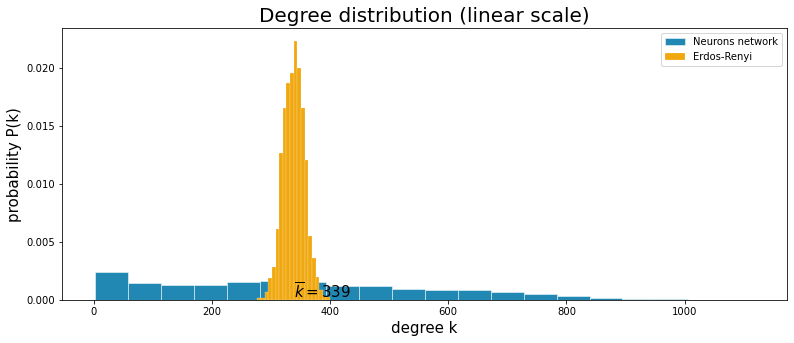

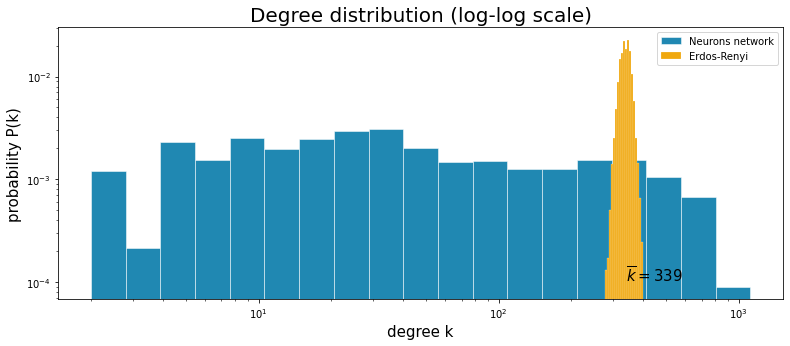

In [26]:
fig,ax=plt.subplots(figsize=(13,5))
plt.hist(degree,density=True,bins=20, facecolor = '#2088B2', edgecolor='#FFFFFF', linewidth=0.5)
plt.hist(degree_ER,density=True,bins=20, facecolor = '#F0A80E', edgecolor='#FFFFFF', linewidth=0.2)
plt.xlabel('degree k', fontsize=15)
plt.ylabel('probability P(k)', fontsize=15)
ax.annotate('$\overline{k}=$'+str(ad), xy=(ad, 0.0001), fontsize = 15)
plt.title('Degree distribution (linear scale)',fontsize = 20)
plt.legend(['Neurons network', 'Erdos-Renyi'])
plt.show()

fig,ax=plt.subplots(figsize=(13,5))
plt.hist(degree,density=True,bins=klist, facecolor = '#2088B2', edgecolor='#FFFFFF', linewidth=0.5)
plt.hist(degree_ER,density=True,bins=klist_ER, facecolor = '#F0A80E', edgecolor='#FFFFFF', linewidth=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('degree k', fontsize=15)
plt.ylabel('probability P(k)', fontsize=15)
ax.annotate('$\overline{k}=$'+str(ad), xy=(ad, 0.0001), fontsize = 15)
plt.title('Degree distribution (log-log scale)',fontsize = 20)
plt.legend(['Neurons network', 'Erdos-Renyi'])
plt.show()

The degree distribution is much wider for the neuron population: in the neuron network it is more likely to find nodes with very low degree or very large degree compared to the average degree, than in the Ednos-Renyi network.

### 5.5. Not a scale-free network
Since we cannot approximate the degree distribution by a Power-Law degree distribution, we cannot describe the network as scale-free. Indeed, $P(k)\sim k^{-\gamma}$ with $\gamma \in [2,3]$ is a very poor approximation of the degree distribution since it is a monotonic decreasing function, represented as a line in a log log plot.

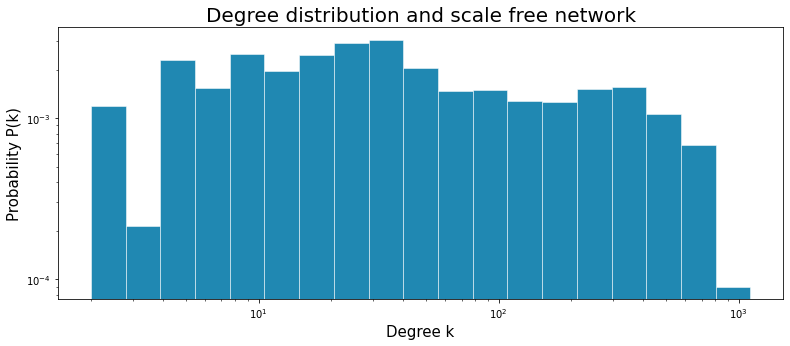

In [27]:
fig,ax=plt.subplots(figsize=(13,5))
plt.hist(degree,density=True,bins=klist, facecolor = '#2088B2', edgecolor='#FFFFFF', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree k', fontsize=15)
plt.ylabel('Probability P(k)', fontsize=15)
plt.title('Degree distribution and scale free network',fontsize = 20)
plt.show()

## Run time
As mentionned in section 3.2, to reduce the run time of the entire file, we decided to draw only 1% of the edges. This allowed the entire file to run in a reasonnable amount of time:

In [28]:
end=time()
print(end-start, 'seconds')
print(int((end-start)//60), 'minutes',int((end-start)%60),'seconds')

355.6898512840271 seconds
5 minutes 55 seconds


In [33]:
! jupyter nbconvert --to html CW2-Victoire_deSaleon.ipynb

[NbConvertApp] Converting notebook CW2-Victoire_deSaleon.ipynb to html
[NbConvertApp] Writing 3682551 bytes to CW2-Victoire_deSaleon.html
